In [1]:
"""
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
https://pytorch.org/docs/0.4.0/_modules/torchvision/datasets/coco.html
https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_e2e.html#sphx-glr-auto-examples-transforms-plot-transforms-e2e-py
https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py


TIL
https://stackoverflow.com/questions/59042121/how-to-test-model-on-pascalvoc-2012-or-coco-test-sets-when-no-annotations-are-pr
https://pytorch.org/vision/main/generated/torchvision.transforms.v2.ToTensor.html
"""

'\nhttps://pytorch.org/tutorials/intermediate/torchvision_tutorial.html\nhttps://pytorch.org/docs/0.4.0/_modules/torchvision/datasets/coco.html\nhttps://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_e2e.html#sphx-glr-auto-examples-transforms-plot-transforms-e2e-py\nhttps://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py\n\n\nTIL\nhttps://stackoverflow.com/questions/59042121/how-to-test-model-on-pascalvoc-2012-or-coco-test-sets-when-no-annotations-are-pr\nhttps://pytorch.org/vision/main/generated/torchvision.transforms.v2.ToTensor.html\n'

In [2]:
# from google.colab import drive
# root = '/content/drive'
# drive.mount(root)

In [3]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
# %cd "/content/drive/Shareddrives/[CS 198+199] Special Project"
# %matplotlib inline

1 - Defining the dataset
====================

In [4]:
# %cd "./data/coco/images"

# !wget http://images.cocodataset.org/zips/train2017.zip
# !wget http://images.cocodataset.org/zips/test2017.zip
# !wget http://images.cocodataset.org/zips/val2017.zip

# !unzip train2017.zip
# !unzip test2017.zip
# !unzip val2017.zip

In [5]:
#!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data
#!cd data && unzip PennFudanPed.zip
# !ls

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

import os
import sys
import torch
import random

from typing import Any, Callable, List, Optional, Tuple, Union

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors, models
from torchvision.transforms.v2 import functional as F

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from torchvision.transforms import v2 as T
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.datasets import CocoDetection, wrap_dataset_for_transforms_v2

# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

from segmentation.helpers import plot
# import segmentation.utils
# from segmentation.train import evaluate, train_one_epoch

from detection.engine import train_one_epoch, evaluate

In [8]:
# PATHS
DRIVE_DIR = "." # "/content/drive/Shareddrives/[CS 198+199] Special Project"
DATASET_DIR =  "c:/Users/Rohan/datasets/coco" # "data/coco"
TRAIN_DIR = DATASET_DIR + "/images/train2017"
TRAIN_ANNOT = DATASET_DIR + "/annotations/instances_train2017.json"
VAL_DIR = DATASET_DIR + "/images/val2017"
VAL_ANNOT = DATASET_DIR + "/annotations/instances_val2017.json"

# Replace the classifier with a new one, one with num_classes (user-defined)
# DATASET CONSTANTS
NUM_CLASSES = 92
BATCH_SIZE = 4
RESIZE = 120

TRAIN_SPLIT = 0.7

# TRAINING PARAMETERS
LEARNING_RATE = 0.005
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005
STEP_SIZE = 3
GAMMA = 0.1
NUM_EPOCHS = 1

In [9]:
# if DRIVE_DIR not in sys.path:
#   sys.path.append(DRIVE_DIR)

DET_PATH = "C:/Users/Rohan/Desktop/Projects/Image-Rescaling/detection"
SEG_PATH = "C:/Users/Rohan/Desktop/Projects/Image-Rescaling/segmentation"

if DET_PATH not in sys.path:
  sys.path.append(DET_PATH)

if SEG_PATH not in sys.path:
  sys.path.append(SEG_PATH)

In [10]:
class CustomCoco(CocoDetection):
    def __init__(self,
                 root,
                 annFile,
                 transform=None,
                 target_transform=None,
                 transforms=None) -> None:
        # from pycocotools.coco import COCO
        super().__init__(root= root, annFile= annFile, transform= transform, target_transform= target_transform, transforms= transforms)

        self.no_annots = open("no_annots.txt").read().splitlines() # All ids with no annotations
        self.ids = sorted([id for id in self.coco.imgs.keys() if str(id) not in self.no_annots])
        
        # You can get the above list by applying your filtering logic to
        # this list :list(self.coco.imgs.keys()) So this would only be have
        # to be done only once.
        # Save it to a text file. This file will now contain the names of
        # images that match your criteria
        # Load that file contents in the init function into self.ids
        # the length would automatically be correct

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        if not isinstance(index, int):
            raise ValueError(f"Index must be of type integer, got {type(index)} instead.")

        id = self.ids[index] # ids should be less
        image = self._load_image(id)
        target = self._load_target(id)

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target
    
    def __len__(self) -> int:
        return len(self.ids)

In [11]:
dataset = CustomCoco(TRAIN_DIR, TRAIN_ANNOT)

# Let's check the format
img, target = dataset.__getitem__(0)
print(f"{type(img) = }\n{type(target) = }\n{type(target[0]) = }\n{target[0].keys() = }")

loading annotations into memory...
Done (t=7.58s)
creating index...
index created!
type(img) = <class 'PIL.Image.Image'>
type(target) = <class 'list'>
type(target[0]) = <class 'dict'>
target[0].keys() = dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])


In [12]:
# Change target format from list of dictionaries ['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'] to dictionary of lists {boxes, labels, masks}
dataset = wrap_dataset_for_transforms_v2(dataset, target_keys=("boxes", "labels", "masks"))

img, target = dataset[0]
print(f"{type(img) = }\n{type(target) = }\n{target.keys() = }")
print(f"{type(target['boxes']) = }\n{type(target['labels']) = }\n{type(target['masks']) = }")

type(img) = <class 'PIL.Image.Image'>
type(target) = <class 'dict'>
target.keys() = dict_keys(['boxes', 'masks', 'labels'])
type(target['boxes']) = <class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'>
type(target['labels']) = <class 'torch.Tensor'>
type(target['masks']) = <class 'torchvision.tv_tensors._mask.Mask'>


Image one index: 11543, Image two index: 8891
<class 'PIL.Image.Image'>


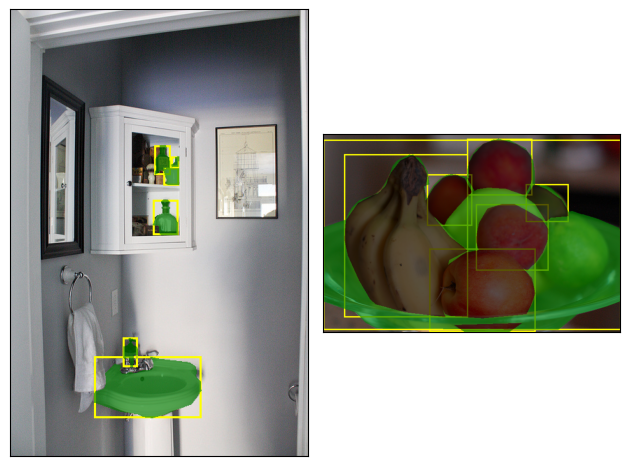

In [13]:
idx_1 = random.randint(0, dataset.__len__())
idx_2 = random.randint(0, dataset.__len__())

print(f"Image one index: {idx_1}, Image two index: {idx_2}")
plot([dataset[idx_1], dataset[idx_2]])

print(type(dataset[idx_1][0]))

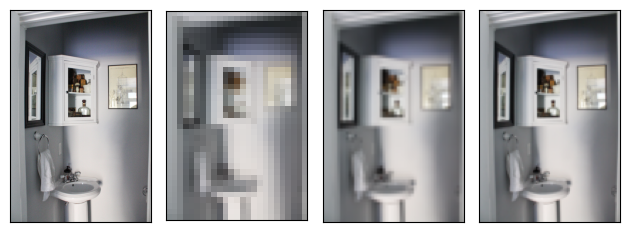

In [14]:
resized_imgs = [T.Resize(size=size)(dataset[idx_1][0]) for size in (25, 50, 100)]

plot([dataset[idx_1][0]] + resized_imgs)

That's all for the dataset. Now let's define a model that can perform
predictions on this dataset.

2.1 - Finetuning from a pretrained model
===================

Let's suppose that you want to start from a model pre-trained on COCO
and want to finetune it for your particular classes. Here is a possible
way of doing it:


In [15]:
# # Load Faster RCNN model pre-trained on COCO
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# # Get number of input features for classifier
# in_features = model.roi_heads.box_predictor.cls_score.in_features

# # Replace pre-trained head with new one
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

2.2 - Modifying the model to add a different backbone
===================================================


In [16]:
# from torchvision.models.detection.rpn import AnchorGenerator

# # Load a pre-trained model for classification and return only the features
# backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features

# # ``FasterRCNN`` needs to know the number of output channels in a backbone. For mobilenet_v2, it's 1280 so we need to add it here
# backbone.out_channels = 1280

# # Let's make the RPN generate 5 x 3 anchors per spatial location, with 5 different sizes and 3 different aspect ratios. We have a Tuple[Tuple[int]] because each feature
# # map could potentially have different sizes and aspect ratios
# anchor_generator = AnchorGenerator(
#     sizes=((32, 64, 128, 256, 512),),
#     aspect_ratios=((0.5, 1.0, 2.0),)
# )

# # Let's define what are the feature maps that we will use to perform the region of interest cropping, as well as the size of the crop after rescaling. if your backbone returns a Tensor, featmap_names is expected to
# # be [0]. More generally, the backbone should return an ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose whichfeature maps to use.
# roi_pooler = torchvision.ops.MultiScaleRoIAlign(
#     featmap_names=['0'],
#     output_size=7,
#     sampling_ratio=2
# )

# # put the pieces together inside a Faster-RCNN model
# model = FasterRCNN(
#     backbone,
#     num_classes=2,
#     rpn_anchor_generator=anchor_generator,
#     box_roi_pool=roi_pooler
# )

3 - Object detection and instance segmentation model for COCO
======================================================================

In our case, we want to finetune from a pre-trained model, given that
our dataset is very small, so we will be following approach number 1.

Here we want to also compute the instance segmentation masks, so we will
be using Mask R-CNN:


In [17]:
def get_model_instance_segmentation(num_classes):
  # Load Mask RCNN model pre-trained on COCO
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

  # Get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features

  # Replace pre-trained head with new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  # Get number of input features for mask classifier
  in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
  hidden_layer = 256

  # Replace mask predictor with new one
  model.roi_heads.mask_predictor = MaskRCNNPredictor(
      in_features_mask,
      hidden_layer,
      num_classes
  )

  return model

That's it, this will make `model` be ready to be trained and evaluated
on your custom dataset.

4 - Putting everything together
===========================


In [18]:
def get_transform(train):
  transforms = []
  if train:
    transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.Resize(size=RESIZE)) # Resize images to be smaller during training

  transforms.append(T.ToImage())
  transforms.append(T.ClampBoundingBoxes())
  transforms.append(T.SanitizeBoundingBoxes())
  transforms.append(T.ToDtype(torch.float32, scale=True))
  # transforms.append(T.ToPureTensor())

  return T.Compose(transforms)

5 - Testing `forward()` method (Optional)
=====================================

Before iterating over the dataset, it\'s good to see what the model
expects during training and inference time on sample data.


In [19]:
# JUST TO KNOW WHAT TO EXPECT BEFORE TRAINING
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

transforms = get_transform(train=True)
dataset = CustomCoco(TRAIN_DIR, TRAIN_ANNOT, transforms=transforms)
dataset = wrap_dataset_for_transforms_v2(dataset, target_keys=("boxes", "labels", "masks"))

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=lambda batch: tuple(zip(*batch)) # utils.collate_fn
)

loading annotations into memory...
Done (t=7.59s)
creating index...
index created!


In [20]:
import numpy as np

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

3
3


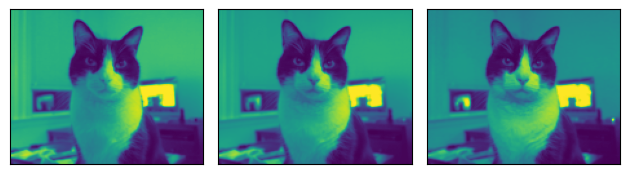

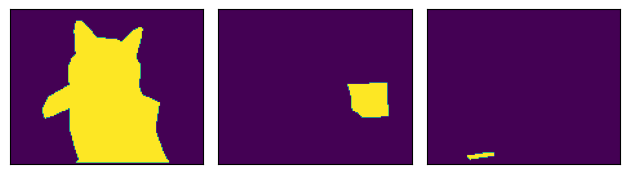

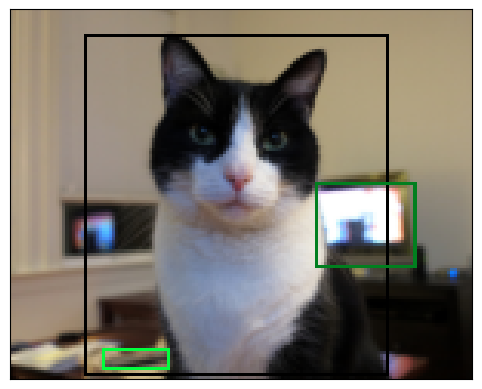

In [21]:
len(data_loader)

imgs, targets = next(iter(data_loader))
plot(imgs[0]) # [Image/Annots][Index (batch)]
plot(targets[0]["masks"]) 
print(len(imgs[0])) # [Image/Annots][Index]
print(len(targets[0])) # [Image/Annots][Index]

bbox = draw_bounding_boxes(imgs[0], targets[0]["boxes"])
show(bbox)

In [22]:
# For training
# images, targets = next(iter(data_loader))
# images = list(image for image in images)
# targets = [{k: v for k, v in t.items()} for t in targets]

# output = model(images, targets) # Returns losses and detections

# print(output)

# # For inference
# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)] # Some random tensors
# predictions = model(x) # Returns predictions

# print(predictions[0])

# model = models.get_model("maskrcnn_resnet50_fpn_v2", weights=None, weights_backbone=None).train()

# for imgs, targets in data_loader:
#     loss_dict = model(imgs, targets)
#     # Put your training logic here

#     print(f"{[img.shape for img in imgs] = }")
#     print(f"{[type(target) for target in targets] = }")
#     for name, loss_val in loss_dict.items():
#         print(f"{name:<20}{loss_val:.3f}")

Let's now write the main function which performs the training and the
validation:


In [23]:
# DEFINE DEVICE, TRAIN AND TEST SETS, AND CORRESPONDING DATA LOADERS

# Train on the GP, or on CPU if GPU not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # torch.device('cuda') if torch.cuda.is_available() else 

# Use dataset and defined transformations
dataset = CustomCoco(TRAIN_DIR, TRAIN_ANNOT, transforms=get_transform(train=True))
dataset_test = CustomCoco(TRAIN_DIR, TRAIN_ANNOT, transforms=get_transform(train=False))

dataset = wrap_dataset_for_transforms_v2(dataset, target_keys=("boxes", "labels", "masks"))
dataset_test = wrap_dataset_for_transforms_v2(dataset_test, target_keys=("boxes", "labels", "masks"))

# Split dataset into train and test
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-int(round(dataset.__len__() * TRAIN_SPLIT))]) # Take first 70% as train set
dataset_test = torch.utils.data.Subset(dataset_test, indices[-int(round(dataset_test.__len__() * TRAIN_SPLIT)):]) # Take the remaining 30% as test set

# Define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(
  dataset,
  batch_size=BATCH_SIZE,
  shuffle=True,
  collate_fn=lambda batch: tuple(zip(*batch)) # utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
  dataset_test,
  batch_size=BATCH_SIZE,
  shuffle=False,
  collate_fn=lambda batch: tuple(zip(*batch)) # utils.collate_fn
)

loading annotations into memory...
Done (t=7.75s)
creating index...
index created!
loading annotations into memory...
Done (t=7.66s)
creating index...
index created!


In [24]:
# LOAD MODEL, DEFINE OPTIMIZER AND LEARNING RATE SCHEDULER

# Get model using helper function
# model = get_model_instance_segmentation(NUM_CLASSES)
model = models.get_model("maskrcnn_resnet50_fpn_v2", weights="DEFAULT", weights_backbone="DEFAULT")

# Move model to right device
model.to(device)

# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=LEARNING_RATE,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY
)

# Construct learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=STEP_SIZE,
    gamma=GAMMA,
)

In [25]:
# TRAIN MODEL

for epoch in range(NUM_EPOCHS):
  # Train for one epoch, printing every 10 iterations
  train_one_epoch(model=model, optimizer=optimizer, data_loader=data_loader_train, device=device, epoch=epoch, print_freq=10)

  # Update learning rate
  lr_scheduler.step()

  # Evaluate on test dataset
  evaluate(model, data_loader_test, device=device)


# Hypothesis for KeyError: 'boxes' - I'm transforming the images to be smaller, 
# so some of the box coordinates exceed the smaller dimensions
# Hypothesis for ValueError: Cannot infer blah blah labels blah blah - 1021 images in COCO have no annotations

c:\Users\Rohan\Desktop\Projects\Image-Rescaling\detection\engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [   0/8795]  eta: 2 days, 19:57:16  lr: 0.000010  loss: 1.4019 (1.4019)  loss_classifier: 0.2699 (0.2699)  loss_box_reg: 0.2350 (0.2350)  loss_mask: 0.5664 (0.5664)  loss_objectness: 0.2629 (0.2629)  loss_rpn_box_reg: 0.0677 (0.0677)  time: 27.8154  data: 0.0337  max mem: 10221
Epoch: [0]  [  10/8795]  eta: 3 days, 19:41:42  lr: 0.000060  loss: 1.1883 (1.2732)  loss_classifier: 0.3439 (0.3387)  loss_box_reg: 0.2445 (0.2418)  loss_mask: 0.3854 (0.4142)  loss_objectness: 0.0378 (0.1943)  loss_rpn_box_reg: 0.0677 (0.0841)  time: 37.5757  data: 0.0334  max mem: 11877
Epoch: [0]  [  20/8795]  eta: 4 days, 4:54:38  lr: 0.000110  loss: 0.9255 (1.1256)  loss_classifier: 0.2612 (0.3155)  loss_box_reg: 0.2300 (0.2334)  loss_mask: 0.3701 (0.3754)  loss_objectness: 0.0352 (0.1366)  loss_rpn_box_reg: 0.0400 (0.0647)  time: 42.0784  data: 0.0324  max mem: 11877
Epoch: [0]  [  30/8795]  eta: 4 days, 0:49:35  lr: 0.000160  loss: 0.8708 (1.0774)  loss_classifier: 0.2315 (0.2984)  loss_box_r

KeyError: 'image_id'

In [ ]:
torch.save(model.state_dict(), "maskrcnn_resnet50_fpn_v2_resize120_1e.pt")

So after one epoch of training, we obtain a COCO-style mAP \> 50, and a
mask mAP of 65.

But what do the predictions look like? Let's take one image in the
dataset and verify


In [ ]:
# # Plot some example
# sample_prediction = read_image(f"{PATH_TO_DATA}/{DATASET}/{IMAGES}/FudanPed00046.png")
# eval_transform = get_transform(train=False)

# model.eval()
# with torch.no_grad():
#   x = eval_transform(sample_prediction)
#   # Convert RGBA to RGB and move to device
#   x = x[:3, ...].to(device)
#   predictions = model([x, ])
#   pred = predictions[0]

# sample_prediction = (255.0 * (sample_prediction - sample_prediction.min()) / (sample_prediction.max() - sample_prediction.min())).to(torch.uint8)
# sample_prediction = sample_prediction[:3, ...]
# pred_labels = [f"Pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
# pred_boxes = pred["boxes"].long()
# output_image = draw_bounding_boxes(sample_prediction, pred_boxes, pred_labels, colors="red")

# masks = (pred["masks"] > 0.7).squeeze(1)
# output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

# plt.figure(figsize=(12, 12))
# plt.imshow(output_image.permute(1, 2, 0))